In [14]:
import pandas as pd

df = pd.read_csv("../data/raw/DataSet_Emails.csv")

df.info()

df.head()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31716 entries, 0 to 31715
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  31716 non-null  int64 
 1   message_id  31716 non-null  int64 
 2   text        31665 non-null  object
 3   label       31716 non-null  int64 
 4   label_text  31716 non-null  object
 5   subject     31442 non-null  object
 6   message     31371 non-null  object
 7   date        31716 non-null  object
dtypes: int64(3), object(5)
memory usage: 1.9+ MB


,Unnamed: 0,message_id,label
count,31716.000000,31716.000000,31716.000000
mean,15857.500000,16854.187539,0.509617
std,9155.764905,9734.616392,0.499915
min,0.000000,0.000000,0.000000
25%,7928.750000,8429.750000,0.000000
50%,15857.500000,16850.500000,1.000000
75%,23786.250000,25295.250000,1.000000
max,31715.000000,33715.000000,1.000000


In [15]:
df.isnull().sum()

Unnamed: 0      0
message_id      0
text           51
label           0
label_text      0
subject       274
message       345
date            0
dtype: int64

In [16]:
df = df.dropna(subset=['text'])
df = df[df['text'].str.strip() != ""]

df.shape

(31665, 8)

In [17]:
df.duplicated().sum()

df = df.drop_duplicates()

df.shape


(31665, 8)

In [18]:
df["subject"] = df["subject"].fillna("")
df["full_text"] = df["subject"] + " " + df["text"]

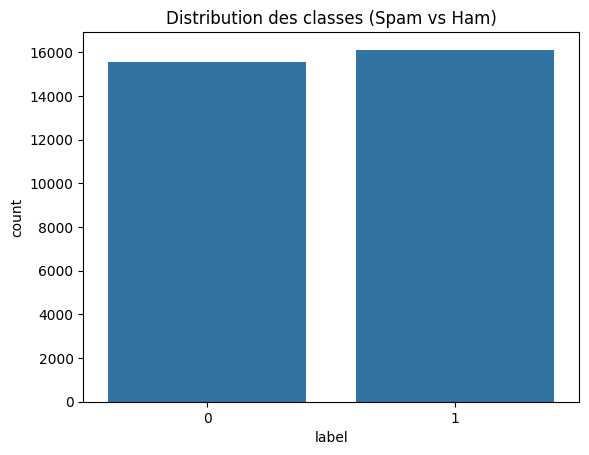

label
1    50.882678
0    49.117322
Name: proportion, dtype: float64

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='label')
plt.title("Distribution des classes (Spam vs Ham)")
plt.show()

df['label'].value_counts(normalize=True) * 100


# WordCloud for SPAM & HAM
---

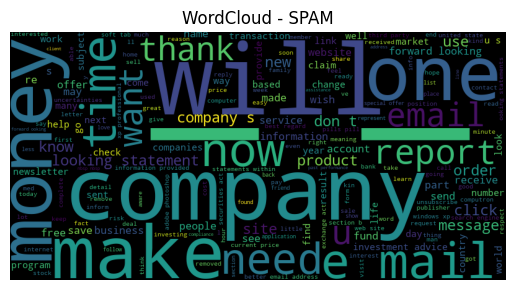

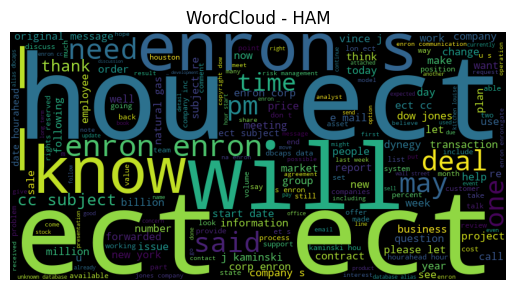

In [20]:
from wordcloud import WordCloud

# SPAM WordCloud
spam_text = " ".join(df[df['label']==1]['full_text'])
wc_spam = WordCloud(width=800, height=400, background_color='black').generate(spam_text)

plt.imshow(wc_spam)
plt.axis("off")
plt.title("WordCloud - SPAM")
plt.show()


# HAM WordCloud
ham_text = " ".join(df[df['label']==0]['full_text'])
wc_ham = WordCloud(width=800, height=400, background_color='black').generate(ham_text)

plt.imshow(wc_ham)
plt.axis("off")
plt.title("WordCloud - HAM")
plt.show()


## Convert full_text to lowercase

In [21]:
df["full_text"] = df["full_text"].str.lower()


# Prétraitement du texte
---

In [22]:
import nltk
import re
import joblib
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# nltk.download("punkt")
# nltk.download("punkt_tab")
# nltk.download("stopwords")


df["tokens"] = df["full_text"].apply(word_tokenize)

def remove_punctuation(tokens):
    cleaned = []
    for w in tokens:
        if re.match(r"^[a-zA-Z]+$", w):  
            cleaned.append(w)
    return cleaned

df["tokens"] = df["tokens"].apply(remove_punctuation)



stop_words = set(stopwords.words("english"))

df["tokens"] = df["tokens"].apply(
    lambda tokens: [w for w in tokens if w not in stop_words]
)


stemmer = PorterStemmer()

df["tokens"] = df["tokens"].apply(
    lambda tokens: [stemmer.stem(w) for w in tokens]
)


df["clean_text"] = df["tokens"].apply(lambda tokens: " ".join(tokens))

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(df["clean_text"])  

joblib.dump(vectorizer, "../models/tfidf_vectorizer.pkl")
print("Vectorizer saved!")

print("Vectorized shape:", X.shape)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oussa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\oussa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oussa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Vectorizer saved!
Vectorized shape: (31665, 113764)


# Save the clean set
---

In [23]:
from scipy import sparse

df["label"].to_csv("../data/clean/y_labels.csv", index=False)
sparse.save_npz("../data/clean/X_vectorized.npz", X)